In [1]:
import numpy as np
import tensorflow as tf
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('..')

import datasets

In [2]:
data_path = '../data/yearly_24.h5'
model_path = '../results/benchmark_all_windows/inp_18__41/weights_epoch_012.h5'

In [3]:
data = datasets.seq2seq_generator(data_path, batch_size=2048)
model = tf.keras.models.load_model(model_path)

In [4]:
batch = iter(data).__next__()

In [5]:
batch[0].shape

TensorShape([2048, 18, 1])

In [6]:
preds = model.predict(batch)

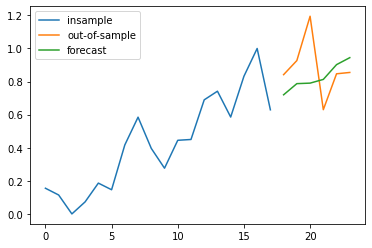

In [7]:
i = 4

plt.plot(range(18), batch[0][i], label='insample')
plt.plot(range(18, 24), batch[1][i], label='out-of-sample')
plt.plot(range(18, 24), preds[i], label='forecast')
plt.legend()

In [8]:
new_batch = np.concatenate([batch[0][:, 6:, :], preds[:, :6, :]], axis=1)

In [9]:
new_batch.shape

(2048, 18, 1)

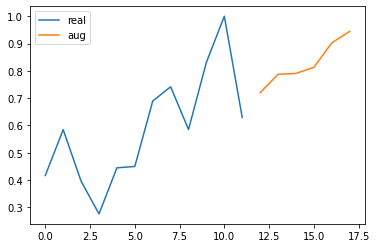

In [10]:
plt.plot(range(12), new_batch[i, :12, 0], label='real')
plt.plot(range(12, 18), new_batch[i, 12:, 0], label='aug')
plt.legend()

In [11]:
preds2 = model.predict(new_batch)

In [12]:
new_batch2 = np.concatenate([new_batch[:, 6:, :], preds2[:, :6, :]], axis=1)
new_batch2.shape

(2048, 18, 1)

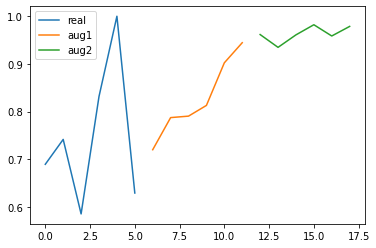

In [13]:
plt.plot(range(6), new_batch2[i, :6, 0], label='real')
plt.plot(range(6, 12), new_batch2[i, 6:12, 0], label='aug1')
plt.plot(range(12, 18), new_batch2[i, 12:, 0], label='aug2')
plt.legend()

In [14]:
def predict_on_unscaled(batch):
    x = batch[..., 0]
    mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
    x_sc = (x - mn) / (mx - mn)
    pred = model(x_sc[..., np.newaxis])
    return pred[..., 0] * (mx - mn) + mn

In [15]:
preds3 = predict_on_unscaled(new_batch)
preds3.shape

TensorShape([2048, 6])

In [16]:
new_batch3 = np.concatenate([new_batch[:, 6:, :], preds3[:, :6, np.newaxis]], axis=1)
new_batch3.shape

(2048, 18, 1)

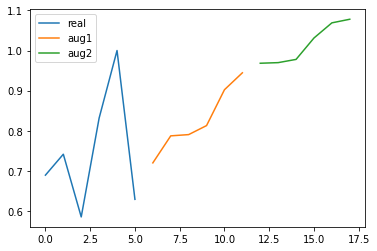

In [17]:
plt.plot(range(6), new_batch3[i, :6, 0], label='real')
plt.plot(range(6, 12), new_batch3[i, 6:12, 0], label='aug1')
plt.plot(range(12, 18), new_batch3[i, 12:, 0], label='aug2')
plt.legend()

In [18]:
preds4 = predict_on_unscaled(new_batch3)
new_batch4 = np.concatenate([new_batch3[:, 6:, :], preds4[:, :6, np.newaxis]], axis=1)
new_batch4.shape

(2048, 18, 1)

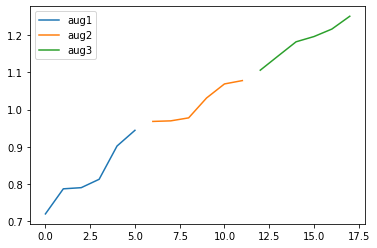

In [19]:
plt.plot(range(6), new_batch4[i, :6, 0], label='aug1')
plt.plot(range(6, 12), new_batch4[i, 6:12, 0], label='aug2')
plt.plot(range(12, 18), new_batch4[i, 12:, 0], label='aug3')
plt.legend()

## Function

In [20]:
def predict_N_ahead(model, batch, total_pred_horizon=24, individual_horizon=6):

    results = [batch]
    batch = batch.numpy()

    def predict_on_unscaled(batch):
        x = batch[..., 0]
        mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1)
        x_sc = (x - mn) / (mx - mn)
        pred = model(x_sc[..., np.newaxis])
        pred_us = pred[..., 0] * (mx - mn) + mn
        return pred_us[..., np.newaxis]

    for i in range(0, total_pred_horizon, individual_horizon):
        preds = predict_on_unscaled(batch)
        batch = np.concatenate([batch[:, individual_horizon:, :], preds[:, :individual_horizon, :]], axis=1)
        results.append(preds[:, :individual_horizon])
        
    results = np.concatenate(results, axis=1)[..., 0]
    mn, mx = results.min(axis=1).reshape(-1, 1), results.max(axis=1).reshape(-1, 1)
    results = (results - mn) / (mx - mn)
    
     
    return results[..., np.newaxis]

In [21]:
aug = predict_N_ahead(model, batch[0])
aug.shape

/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


(2048, 42, 1)

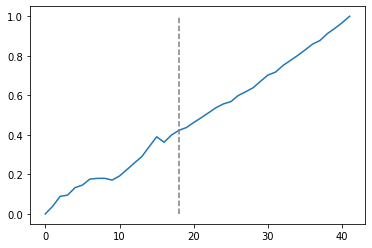

In [22]:
i = 3

plt.plot(aug[i, :, 0])
plt.plot([18, 18], [0, 1], ls='--', color='0.5')

In [23]:
def make_augmented_dataset(model, data_it, total_horizon=24, individual_horizon=6, num_samples=235460,
                           batch_size=2048, real_insample=12):

    aug_batches = []
    for _ in tqdm(range(num_samples//batch_size+1)):
        batch = data_it.__next__()
        aug_batch = predict_N_ahead(model, batch[0], total_pred_horizon=total_horizon-real_insample,
                                           individual_horizon=individual_horizon)

        aug_batches.append(aug_batch)
        
    start = batch[0].shape[1] - real_insample
    
    return np.concatenate(aug_batches)[:, start:start+total_horizon]

In [24]:
aug_dataset = make_augmented_dataset(model, data.__iter__())

  0%|          | 0/115 [00:00<?, ?it/s]/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 115/115 [00:27<00:00,  4.23it/s]


In [25]:
aug_dataset.shape

(235520, 24, 1)

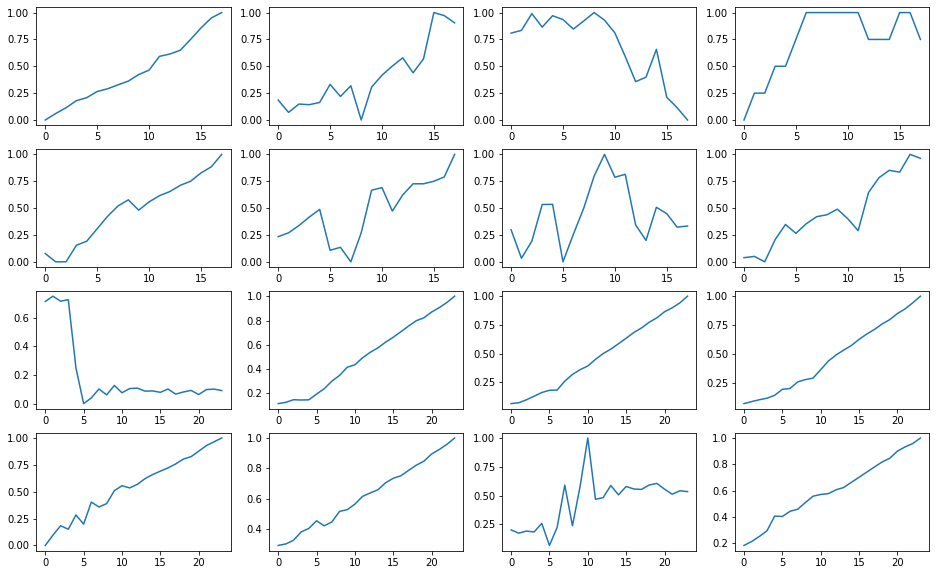

In [26]:
data_it = data.__iter__()
batch = data_it.__next__()

ind = np.random.permutation(aug_dataset.shape[0])[:8]

plt.figure(figsize=(16, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    plt.plot(batch[0][i, :, 0])
    
for i in range(8):
    ax = plt.subplot(4, 4, i+9)
    plt.plot(aug_dataset[ind[i], :, 0])

In [27]:
aug_dataset.shape

(235520, 24, 1)

## predict one one points

In [28]:
aug_dataset = make_augmented_dataset(model, data.__iter__(), total_horizon=24, individual_horizon=1, real_insample=12)

  1%|          | 1/115 [00:01<03:13,  1.70s/it]/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 115/115 [02:40<00:00,  1.40s/it]


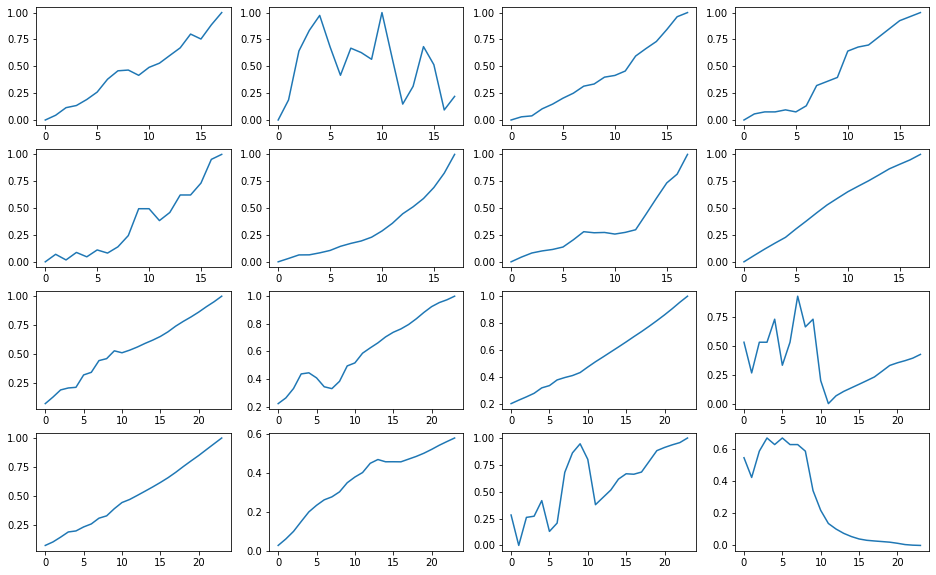

In [29]:
batch = data_it.__next__()

ind = np.random.permutation(aug_dataset.shape[0])[:8]

plt.figure(figsize=(16, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    plt.plot(batch[0][i, :, 0])
    
for i in range(8):
    ax = plt.subplot(4, 4, i+9)
    plt.plot(aug_dataset[ind[i], :, 0])

## predict three three points

In [30]:
aug_dataset = make_augmented_dataset(model, data.__iter__(), total_horizon=24, individual_horizon=3, real_insample=12)

  0%|          | 0/115 [00:00<?, ?it/s]/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 115/115 [00:54<00:00,  2.10it/s]


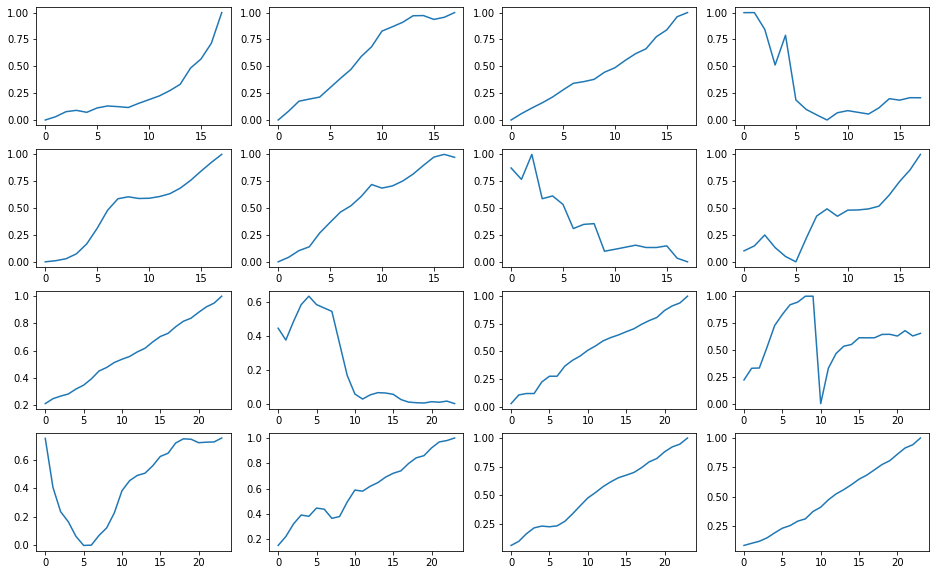

In [31]:
batch = data_it.__next__()

ind = np.random.permutation(aug_dataset.shape[0])[:8]

plt.figure(figsize=(16, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    plt.plot(batch[0][i, :, 0])
    
for i in range(8):
    ax = plt.subplot(4, 4, i+9)
    plt.plot(aug_dataset[ind[i], :, 0])

In [32]:
aug_dataset = make_augmented_dataset(model, data.__iter__(), total_horizon=24, individual_horizon=6, real_insample=16)

  1%|          | 1/115 [00:00<01:36,  1.19it/s]/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 115/115 [00:27<00:00,  4.24it/s]


In [33]:
data_it

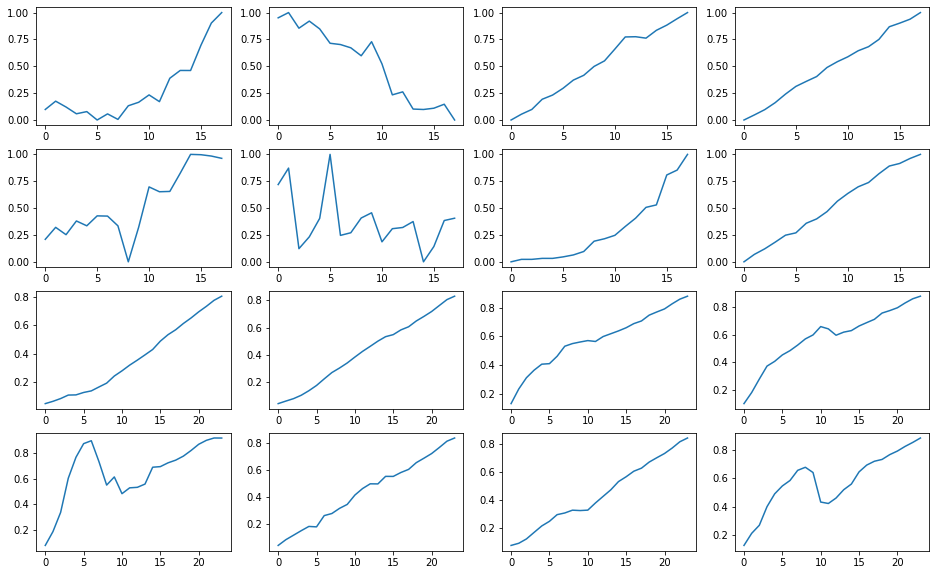

In [34]:
batch = data_it.__next__()

ind = np.random.permutation(aug_dataset.shape[0])[:8]

plt.figure(figsize=(16, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    plt.plot(batch[0][i, :, 0])
    
for i in range(8):
    ax = plt.subplot(4, 4, i+9)
    plt.plot(aug_dataset[ind[i], :, 0])

In [35]:
aug_dataset = make_augmented_dataset(model, data.__iter__(), total_horizon=24, individual_horizon=6, real_insample=10)

  0%|          | 0/115 [00:00<?, ?it/s]/home/thanos/.envs/aug/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
100%|██████████| 115/115 [00:39<00:00,  2.90it/s]


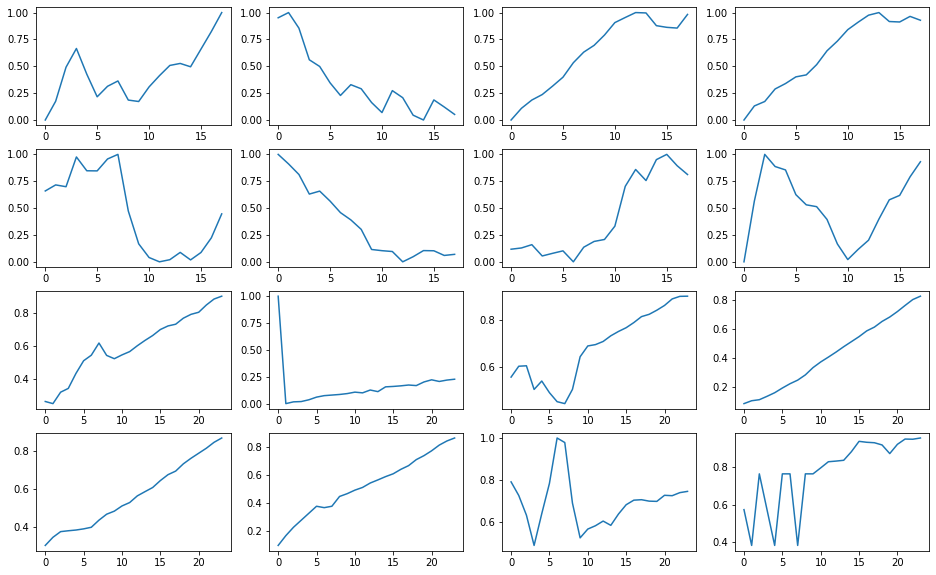

In [36]:
batch = data_it.__next__()

ind = np.random.permutation(aug_dataset.shape[0])[:8]

plt.figure(figsize=(16, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i+1)
    plt.plot(batch[0][i, :, 0])
    
for i in range(8):
    ax = plt.subplot(4, 4, i+9)
    plt.plot(aug_dataset[ind[i], :, 0])